In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
path_train = "../input/covid-19-nlp-text-classification/Corona_NLP_train.csv"
path_test = "../input/covid-19-nlp-text-classification/Corona_NLP_test.csv"
df_train = pd.read_csv(path_train, encoding = 'latin1')
df_test = pd.read_csv(path_test, encoding = 'latin1')

In [3]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
#drop the columns we don't need
df_train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace = True)
df_test.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace = True)

In [5]:
#as in the first step we'll consider everything either positive or negative
#and drop neutral

In [6]:
df_train = df_train[(df_train.Sentiment == 'Extremely Positive') | (df_train.Sentiment == 'Positive') | (df_train.Sentiment == 'Extremely Negative') | (df_train.Sentiment == 'Negative')]
df_test = df_test[(df_test.Sentiment == 'Extremely Positive') | (df_test.Sentiment == 'Positive') | (df_test.Sentiment == 'Extremely Negative') | (df_test.Sentiment == 'Negative')]

In [7]:
def blackNwhite(text):
    if text in ['Extremely Positive', 'Positive']:
        return 'positive'
    elif text in ['Extremely Negative', 'Negative']:
        return 'negative'
    else:
        return text

In [8]:
df_train.Sentiment = df_train.Sentiment.apply(blackNwhite)
df_test.Sentiment = df_test.Sentiment.apply(blackNwhite)

In [9]:
X_train = df_train.OriginalTweet
Y_train = df_train.Sentiment
X_test = df_test.OriginalTweet
Y_test = df_test.Sentiment

In [10]:
stop_words = stopwords.words("english")
def clean_text(text):
    text = text.lower()           # converting to lowercase
    text = re.sub("@\S+", " ", text)  
    text = re.sub("https*\S+", " ", text)      #\S - не пробел 
    text = re.sub("www\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)        # remove all numbers
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)     # remove punctuations
    text = re.sub('\n', ' ', text)        
    text = re.sub('\s{2,}',' ', text)        # remove extra spaces
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [11]:
def makediglabel(text):
    if text == 'positive':
        return 0.0
    elif text == 'negative':
        return 1.0
    else:
        return -1.0

In [12]:
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)
Y_train = Y_train.apply(makediglabel)
Y_test = Y_test.apply(makediglabel)

In [13]:
whole_text = ""
for i in X_train:
    whole_text += i + ' '
for i in X_test:
    whole_text += i + ' '

In [14]:
tokens = word_tokenize(whole_text)
lemmatizer = WordNetLemmatizer()
lemtok = [lemmatizer.lemmatize(t) for t in tokens]
dictionary = list(set(lemtok))

In [15]:
len(dictionary)

29574

In [16]:
def convert(text):
    tok = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(t) for t in tok]
    res = [dictionary.index(i) for i in lem]
    return res

In [17]:
X_train = X_train.apply(convert)
X_test = X_test.apply(convert)

In [18]:
def vectorize_sequences(sequences, dimension = 30000):#dims
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [19]:
x_train = vectorize_sequences(X_train)
x_test = vectorize_sequences(X_test)

In [20]:
y_train = np.asarray(Y_train).astype("float32")
y_test = np.asarray(Y_test).astype("float32")

In [21]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2,
                    shuffle = True,
                    verbose = 2)

2022-01-27 09:21:19.184550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 09:21:19.288986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 09:21:19.290010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 09:21:19.292973: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/10


2022-01-27 09:21:33.251902: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 802680000 exceeds 10% of free system memory.
2022-01-27 09:21:34.049121: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 802680000 exceeds 10% of free system memory.


53/53 - 6s - loss: 0.5837 - accuracy: 0.7535 - val_loss: 0.5044 - val_accuracy: 0.8128
Epoch 2/10
53/53 - 3s - loss: 0.4276 - accuracy: 0.8611 - val_loss: 0.4149 - val_accuracy: 0.8447
Epoch 3/10
53/53 - 3s - loss: 0.3343 - accuracy: 0.8952 - val_loss: 0.3626 - val_accuracy: 0.8571
Epoch 4/10
53/53 - 3s - loss: 0.2729 - accuracy: 0.9153 - val_loss: 0.3299 - val_accuracy: 0.8677
Epoch 5/10
53/53 - 3s - loss: 0.2306 - accuracy: 0.9283 - val_loss: 0.3123 - val_accuracy: 0.8717
Epoch 6/10
53/53 - 3s - loss: 0.2000 - accuracy: 0.9381 - val_loss: 0.3060 - val_accuracy: 0.8737
Epoch 7/10
53/53 - 3s - loss: 0.1766 - accuracy: 0.9453 - val_loss: 0.3047 - val_accuracy: 0.8767
Epoch 8/10
53/53 - 3s - loss: 0.1585 - accuracy: 0.9506 - val_loss: 0.3080 - val_accuracy: 0.8765
Epoch 9/10
53/53 - 3s - loss: 0.1433 - accuracy: 0.9554 - val_loss: 0.3147 - val_accuracy: 0.8783
Epoch 10/10
53/53 - 3s - loss: 0.1317 - accuracy: 0.9588 - val_loss: 0.3223 - val_accuracy: 0.8743


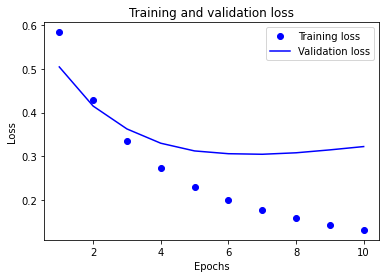

In [22]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.37078073620796204
Test accuracy: 0.8615916967391968
